In [1]:
%cd ..

/home/ccchang/xKV


In [2]:
import torch
from utils import load_model_and_tokenizer

## Prepare Model & Calibrated KV-Cache

In [3]:
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"  # Or any other Llama checkpoint available
model, tokenizer = load_model_and_tokenizer(model_name)
model = model.eval()
model = model.cuda()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
# We'll collect outputs for all layers in these lists
collected_k_outputs = []
collected_v_outputs = []
def k_proj_hook(module, input, output):
    """
    module: The layer that produced this output (k_proj).
    input:  The input to k_proj.
    output: The output from k_proj (shape [batch_size, seq_len, hidden_dim]).
    """
    # Detach to avoid growing the autograd graph
    collected_k_outputs.append(output.detach().cpu())

def v_proj_hook(module, input, output):
    """
    Same logic as k_proj_hook, but for v_proj.
    """
    collected_v_outputs.append(output.detach().cpu())


In [5]:
num_layers = len(model.model.layers)
hooks_k = []
hooks_v = []
for layer_idx in range(num_layers):
    # Access the i-th layer
    layer = model.model.layers[layer_idx].self_attn
    
    # Register forward hooks
    hook_k = layer.k_proj.register_forward_hook(k_proj_hook)
    hook_v = layer.v_proj.register_forward_hook(v_proj_hook)
    
    hooks_k.append(hook_k)
    hooks_v.append(hook_v)

In [6]:
from evaluate.data.dataset import Dataset

In [7]:
dataset = Dataset("ruler/niah_multivalue", tokenizer, 65536, 4, -1, 1)

In [8]:
with torch.no_grad():
    for i in range(dataset.num_samples):
        print(f"Processing {i}")
        prompt = dataset.tokenized_prompts[i]
        input_ids = prompt["input_ids"].cuda()
        attention_mask = prompt["attention_mask"].cuda()
        model(input_ids, attention_mask=attention_mask)
        break


Processing 0


In [9]:
for hook in hooks_k:
    hook.remove()
for hook in hooks_v:
    hook.remove()

In [10]:
print("Num samles (layers) collected:", len(collected_k_outputs))

Num samles (layers) collected: 32


## Analysis Function

In [11]:
import torch
import torch.nn.functional as F

def linear_cka_centered_torch(kv1: torch.Tensor, kv2: torch.Tensor) -> torch.Tensor:
    """
    A *centered* linear CKA, as in Kornblith et al. (2019), for (L, D) Tensors.
    This subtracts each row's mean from kv1, kv2 before computing the norm-based formula.
    
    Steps:
      1. Row-center each representation (i.e., subtract column means).
      2. Compute Frobenius norms of X^T X, Y^T Y, X^T Y on the centered data.
      3. Return (||X^T Y||_F^2) / (||X^T X||_F * ||Y^T Y||_F).

    Note:
      - 'Row-center' means we subtract the *column* mean for each dimension (the usual approach 
        in CKA references). This ensures the average vector over all tokens is zero.

    Args:
      kv1: shape (L, D)
      kv2: shape (L, D)

    Returns:
      cka_value: a scalar torch.Tensor
    """
    assert kv1.shape[1] == kv2.shape[1], "kv1, kv2 must have same embedding dimension."

    # Move to GPU if desired
    device = kv1.device
    kv1 = kv1.to(device)
    kv2 = kv2.to(device)
    
    # 1. Row-center each representation. 
    #    (Compute column means & subtract => each dimension has mean 0 across L)
    kv1_centered = kv1 - kv1.mean(dim=0, keepdim=True)
    kv2_centered = kv2 - kv2.mean(dim=0, keepdim=True)
    
    # 2. Norm computations
    xtx = (kv1_centered.T @ kv1_centered).norm(p='fro')
    yty = (kv2_centered.T @ kv2_centered).norm(p='fro')
    xty = (kv1_centered.T @ kv2_centered).norm(p='fro')

    # Handle degenerate case
    if xtx == 0 or yty == 0:
        return torch.tensor(0.0, device=device, dtype=kv1.dtype)

    # 3. Linear CKA formula
    cka_value = (xty ** 2) / (xtx * yty)

    return cka_value


def principal_angle_subspace_similarity_torch(
    kv1: torch.Tensor, 
    kv2: torch.Tensor, 
    rank: int = None
) -> torch.Tensor:
    """
    Compute a subspace similarity between two matrices kv1, kv2 by comparing 
    their top-r principal components (SVD subspace).

    Steps:
      1. SVD each matrix kv1, kv2 => U1, S1, V1 and U2, S2, V2
      2. Truncate U1, U2 to top-`rank` columns (top singular vectors)
      3. Multiply M = U1_r^T @ U2_r
      4. SVD(M) => get singular values sigma_i
      5. Return average of (sigma_i^2) => a subspace overlap in [0,1]

    Args:
      kv1: shape (L, D)
      kv2: shape (L, D)
      rank: how many singular vectors to keep (top-r). If None, 
            we use min(L, D) for each input to get the full basis.

    Returns:
      subspace_sim: scalar tensor in [0,1], the average of sigma^2 over i.
                    1 => identical subspaces at that rank
    """
    # Determine default rank
    if rank is None:
        rank = min(kv1.shape[0], kv1.shape[1], kv2.shape[0], kv2.shape[1])

    # SVD (full_matrices=False) ensures shapes are (L, D) => (L, min(L,D))
    U1, S1, V1 = torch.svd_lowrank(kv1, q=rank)
    U2, S2, V2 = torch.svd_lowrank(kv2, q=rank)

    # Truncate
    U1_r = U1[:, :rank]  # shape (L, rank)
    U2_r = U2[:, :rank]  # shape (L, rank)

    # Multiply => shape (rank, rank)
    M = U1_r.transpose(0, 1) @ U2_r

    # SVD on M
    # The singular values of M measure how well subspaces overlap
    _, sigma, _ = torch.linalg.svd(M, full_matrices=False)

    # We return the average of sigma^2
    subspace_sim = (sigma**2).sum() / rank
    return subspace_sim
  
  
def average_cosine_similarity_torch(kv1: torch.Tensor, kv2: torch.Tensor) -> torch.Tensor:
    """
    Compute the average rowwise cosine similarity between kv1 and kv2.

    Specifically, for i in [0..L-1], we do:
      cosSim( kv1[i], kv2[i] ) =  (kv1[i] dot kv2[i]) / (||kv1[i]|| * ||kv2[i]||)
    and then average these values over the batch dimension L.

    Args:
      kv1: (L, D) - e.g. L rows of D-dimensional embeddings
      kv2: (L, D) - same shape

    Returns:
      A scalar torch.Tensor representing the mean cosine similarity in [-1, 1].
    """
    assert kv1.shape == kv2.shape, "kv1 and kv2 must have the same shape"

    # If needed, move to same device (assuming kv1, kv2 are on same device)
    # you can also do kv1 = kv1.to(device), kv2 = kv2.to(device) if needed

    # F.cosine_similarity returns a tensor of shape (L,),
    # each element is the cosine similarity of row i in kv1 and row i in kv2.
    cos_sims = F.cosine_similarity(kv1, kv2, dim=0)

    # Take the average
    avg_cosine_sim = cos_sims.mean()
    return avg_cosine_sim


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tensor(w, ax=None, title=None, x_label="Dims", y_label="Token"):
    # Prepare the data for plotting
    x = np.arange(w.shape[0])  # Dims
    y = np.arange(w.shape[1])  # Seqlen
    x, y = np.meshgrid(x, y)

    # Use the provided axis or create a new figure and axis
    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
    else:
        fig = None

    # Plot the surface
    surf = ax.plot_surface(x, y, w.T, cmap='coolwarm')
    ax.xaxis.set_tick_params(pad=-6, size=13)
    ax.yaxis.set_tick_params(pad=-4, size=13)
    ax.zaxis.set_tick_params(pad=-3, size=13)
    
    # Set title and labels
    if title is not None:
        ax.set_title(title, fontsize=15)
    ax.set_ylabel(x_label, labelpad=-5, fontsize=14)
    ax.set_xlabel(y_label, labelpad=-1, fontsize=14)
    ax.set_zlabel('Absolute Activation Value', labelpad=-5, fontsize=14)

    return fig

def plot_vector(w, ax=None, title=None, x_label="Dims", y_label="Value"):
    # Use the provided axis or create a new figure and axis
    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
    else:
        fig = None

    # Plot the vector
    ax.plot(w)
    ax.xaxis.set_tick_params(size=16)
    ax.yaxis.set_tick_params(size=16)
    if x_label is not None:
        ax.set_xlabel(x_label, fontsize=14)
    if y_label is not None:
        ax.set_ylabel(y_label, fontsize=14)
    # Set title
    if title is not None:
        ax.set_title(title)

    return fig


def plot_side_by_side(tensors, titles=None, plot_type='tensor', saved_path = None):
    """
    Plot multiple tensors or vectors side by side.

    Args:
        tensors: List of tensors or vectors to plot.
        titles: List of titles for each plot (optional).
        plot_type: Type of plot ('tensor' for 3D tensor, 'vector' for 1D vector).
    """
    num_plots = len(tensors)
    fig, axs = plt.subplots(1, num_plots, figsize=(6 * num_plots + 3, 6), subplot_kw={'projection': '3d'} if plot_type == 'tensor' else {})

    # In case of only one plot, axs won't be an array; make it an array for consistency
    if num_plots == 1:
        axs = [axs]

    # Plot each tensor/vector
    for i, (tensor, ax) in enumerate(zip(tensors, axs)):
        title = titles[i] if titles is not None else None
        if plot_type == 'tensor':
            plot_tensor(tensor, ax=ax, title=title)
        elif plot_type == 'vector':
            plot_vector(tensor, ax=ax, title=title)
        else:
            raise ValueError("Unsupported plot type. Use 'tensor' or 'vector'.")

    plt.tight_layout()
    if saved_path is not None:
        plt.savefig(saved_path)
    plt.show()

In [13]:
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns

def plot_heatmap(tensor, title="Heatmap", custom_colors=None, colorbar=True, 
                 x_label="", y_label="", font_size=14, tick_font_size=12, interpolation="bilinear"):
    """
    Plots a smooth heatmap from a 2D PyTorch tensor with a custom color gradient.

    Args:
        tensor (torch.Tensor): 2D tensor to plot.
        title (str): Title of the heatmap.
        custom_colors (list): List of 6 colors for the colormap.
        colorbar (bool): Whether to show the colorbar.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        font_size (int): Font size for title and labels.
        tick_font_size (int): Font size for x and y ticks.
        interpolation (str): Interpolation method for smooth transitions (e.g., 'bilinear', 'bicubic').
    """
    if not isinstance(tensor, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")
    
    if tensor.dim() != 2:
        raise ValueError("Input tensor must be 2D.")
    
    # Convert tensor to numpy
    matrix = tensor.detach().cpu().numpy()

    # Define a custom colormap
    # if custom_colors and len(custom_colors) >= 2:
    #     cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=256)
    # else:
    #     cmap = "coolwarm"  # Default colormap if none provided

    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    #cmap = sns.color_palette("vlag", as_cmap=True)
    #cmap = 'coolwarm'
    # Plot heatmap with smooth transitions
    plt.figure(figsize=(7, 6))
    im = plt.imshow(matrix, cmap=cmap, aspect='auto')

    # Set title and labels
    plt.title(title, fontsize=23)
    plt.xlabel(x_label, fontsize=21)
    plt.ylabel(y_label, fontsize=21)
    
    # Configure tick parameters
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)

    # Configure colorbar
    if colorbar:
        cbar = plt.colorbar(im)
        cbar.ax.tick_params(labelsize=19)
    plt.savefig(f"{title}.pdf", bbox_inches='tight')
    plt.show()

## CKA Analysis

In [14]:
cka_matrix = torch.zeros(num_layers, num_layers)
mode = "Value"
if mode == "Key":
    for i in range(num_layers):
        for j in range(num_layers):
            ki = collected_k_outputs[i]
            kj = collected_k_outputs[j]
            
            assert ki.shape == kj.shape
            assert ki.shape[0] == 1 # batch size is 1
            
            ki = ki.squeeze(0).cuda().float()
            kj = kj.squeeze(0).cuda().float()
            cka_matrix[i, j] = linear_cka_centered_torch(ki, kj)
            print(f"CKA({i}, {j}) = {cka_matrix[i, j]}")
            
            del ki, kj
elif mode == "Value":
    for i in range(num_layers):
        for j in range(num_layers):
            vi = collected_v_outputs[i]
            vj = collected_v_outputs[j]
            
            assert vi.shape == vj.shape
            assert vi.shape[0] == 1

            vi = vi.squeeze(0).cuda().float()
            vj = vj.squeeze(0).cuda().float()
            cka_matrix[i, j] = linear_cka_centered_torch(vi, vj)
            print(f"CKA({i}, {j}) = {cka_matrix[i, j]}")
elif mode == "KV":
    for i in range(num_layers):
        for j in range(num_layers):
            ki = collected_k_outputs[i]
            vj = collected_v_outputs[j]
            
            assert not torch.all(ki == vj)
            
            assert ki.shape == vj.shape
            assert ki.shape[0] == 1
            
            ki = ki.squeeze(0).cuda().float()
            vj = vj.squeeze(0).cuda().float()
            cka_matrix[i, j] = linear_cka_centered_torch(ki, vj)
            print(f"CKA({i}, {j}) = {cka_matrix[i, j]}")

CKA(0, 0) = 1.0
CKA(0, 1) = 0.7480279207229614
CKA(0, 2) = 0.6216321587562561
CKA(0, 3) = 0.6139110326766968
CKA(0, 4) = 0.4738776683807373
CKA(0, 5) = 0.4271252453327179
CKA(0, 6) = 0.4041573703289032
CKA(0, 7) = 0.3243386149406433
CKA(0, 8) = 0.23169584572315216
CKA(0, 9) = 0.20109744369983673
CKA(0, 10) = 0.20325502753257751
CKA(0, 11) = 0.1880335956811905
CKA(0, 12) = 0.17415925860404968
CKA(0, 13) = 0.13304568827152252
CKA(0, 14) = 0.28218504786491394
CKA(0, 15) = 0.3514581620693207
CKA(0, 16) = 0.3829902708530426
CKA(0, 17) = 0.33926472067832947
CKA(0, 18) = 0.45175549387931824
CKA(0, 19) = 0.5026973485946655
CKA(0, 20) = 0.5042912364006042
CKA(0, 21) = 0.4108718931674957
CKA(0, 22) = 0.4504305422306061
CKA(0, 23) = 0.4343186616897583
CKA(0, 24) = 0.4793252646923065
CKA(0, 25) = 0.4499456286430359
CKA(0, 26) = 0.4420457184314728
CKA(0, 27) = 0.48942795395851135
CKA(0, 28) = 0.46737030148506165
CKA(0, 29) = 0.4539920687675476
CKA(0, 30) = 0.3599538505077362
CKA(0, 31) = 0.38936316

In [15]:
cmap = sns.diverging_palette(240, 10)

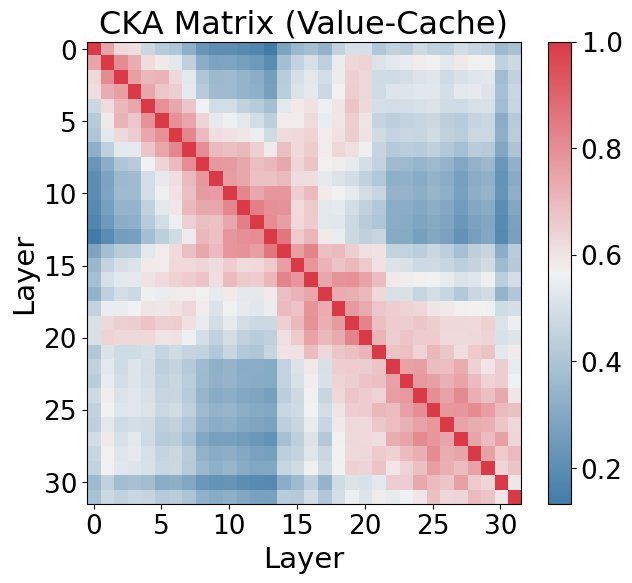

In [16]:
custom_colors = ["#D93F49", "#E28187", "#EBBFC2", "#D5E1E3", "#AFC9CF", "#8FB4BE"]  
custom_colors = custom_colors[::-1]  # Reverse the colors for better contrast
plot_heatmap(cka_matrix, title=f"CKA Matrix ({mode}-Cache)", colorbar=True, x_label="Layer", y_label="Layer", custom_colors=custom_colors)